In [8]:
#@title Copyright 2023 Google LLC. { display-mode: "form" }
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="http://colab.research.google.com/github/google/earthengine-community/blob/master/guides/linked/Earth_Engine_training_patches_getPixels.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/google/earthengine-community/blob/master/guides/linked/Earth_Engine_training_patches_getPixels.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Download training patches from Earth Engine

This demonstration shows how to get patches of imagery from Earth Engine assets.  Specifically, use `getPixels` calls in parallel to write a TFRecord file.

## Imports

In [1]:
import concurrent
import ee
import google
import io
import json
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import multiprocessing
import numpy as np
import requests
import tensorflow as tf

from google.api_core import retry
from google.colab import auth
from google.protobuf import json_format
from IPython.display import Image
from matplotlib import rc
from tqdm.notebook import tqdm

rc('animation', html='html5')

## Authentication and initialization

Use the Colab auth widget to get credentials, then use them to initialize Earth Engine.  During initialization, be sure to specify a project and Earth Engine's [high-volume endpoint](https://developers.google.com/earth-engine/cloud/highvolume), in order to make automated requests.

In [2]:
# REPLACE WITH YOUR PROJECT!
PROJECT = 'ee-clarkwakeland7'

In [3]:
auth.authenticate_user()

In [4]:
credentials, _ = google.auth.default()
ee.Initialize(credentials, project=PROJECT)

## Define variables

In [5]:
# REPLACE WITH YOUR BUCKET!
OUTPUT_FILE = 'gs://exampl_ee_bucket/test_images.tfrecord.gz'

# MODIS vegetation indices, 16-day.
VNP13A1 = ee.ImageCollection("NASA/VIIRS/002/VNP13A1").select('NDVI')

# Output resolution in meters.
SCALE = 1000

# Bay area.
ROI = ee.Geometry.Rectangle(
    [-125.20119889981346, 42.187882211250646,
    -113.78341106988069, 33.26978475398253])

# Number of samples per ROI, per year, and per TFRecord file.
N = 64

# A random sample of N locations in the ROI as a list of GeoJSON points.
SAMPLE = ee.FeatureCollection.randomPoints(
    region=ROI, points=N, maxError=1).aggregate_array('.geo').getInfo()

# The years from which to sample every 16-day composite.
YEARS = np.arange(2010, 2023)

In [6]:
GRIDMET = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').select('erc')
GRIDMET = GRIDMET.filterBounds(ROI).filter(ee.Filter.date('2020-05-01', '2020-12-31'))
VNP13A1 =  ee.ImageCollection("NASA/VIIRS/002/VNP13A1").select('NDVI')
filtered_VNP13A1 = VNP13A1.filterBounds(ROI).filterDate('2020-08-01', '2020-08-07') # Adjust dates as needed
imageG = GRIDMET.first()
band_names = imageG.bandNames()
band_names.getInfo()

['erc']

In [15]:
# REPLACE WITH YOUR BUCKET!
OUTPUT_FILE = 'gs://exampl_ee_bucket/test_images.tfrecord.gz'

# MODIS vegetation indices, 16-day.
VNP13A1 =  ee.ImageCollection("NASA/VIIRS/002/VNP13A1").select('NDVI')

# Output resolution in meters.
SCALE = 250

# Bay area.
ROI = ee.Geometry.Rectangle(
    [-122.53559186128896, 37.81307980878117,
    -122.35606622214631,  37.70342746748379])


In [6]:
feature = filtered_VNP13A1.first()  # Example: first image
rep_image = feature.reproject(crs='EPSG:4326', scale=1000)
rep_imageG = imageG.reproject(crs='EPSG:4326', scale=1000)
data = rep_image.sampleRectangle(region = ROI, properties=['NDVI'], defaultValue=0)
print(data)
dataG = rep_imageG.sampleRectangle(region = ROI, properties=['erc'], defaultValue=0)
data_dict = data.getInfo()
dataG_dict = dataG.getInfo()
vals = data_dict['properties']['NDVI']
valsG = dataG_dict['properties']['erc']

NameError: name 'filtered_VNP13A1' is not defined

In [11]:
ROI = ee.Geometry.Rectangle(
    [-123.20119889981346, 39.187882211250646,
    -119.78341106988069, 36.26978475398253])

In [7]:
ROI = ee.Geometry.Rectangle(
    [-125.606463, 48.938524,
    -71.78341106988069, 29.99975398253])

In [8]:
# Fire mask data from MOD14A1 dataset
MOD14A1 = ee.ImageCollection('MODIS/061/MOD14A1').select('FireMask')
fire_mask = MOD14A1.filterBounds(ROI).filterDate('2020-08-16', '2020-08-22') # Adjust dates as needed
feature = fire_mask.max()  # Example: first image
mask_points = feature.gt(6)
feature = feature.updateMask(mask_points)
fire_image = feature.reproject(crs='EPSG:4326', scale=1000)
# dataF = fire_image.sampleRectangle(region = ROI, properties=['FireMask'], defaultValue=0)
# mos = fire_mask.mosaic().gte(4)
# f_dict = dataF.getInfo()
# valsF = f_dict['properties']['FireMask']
# #

In [9]:
def add_coords(feature):
  return feature.set(
      longitude=feature.geometry().coordinates().get(0),
      latitude=feature.geometry().coordinates().get(1))

In [10]:
firepoints = fire_image.reduceToVectors(
    geometry = ROI,
    scale = 1000,
    geometryType = 'polygon',
    eightConnected = False,
    maxPixels = 1e13
)
print(len(firepoints.getInfo()["features"]))

1050


[-89.95729255172888, -89.9303430932053, -89.9303430932053, -89.95729255172888, -89.95729255172888, -89.94830939888769, -89.93932624604649, -89.93932624604649, -89.95729255172888, -89.95729255172888, -89.94830939888769, -89.94830939888769, -89.99322516309367, -89.98424201025247, -89.98424201025247, -89.97525885741128, -89.97525885741128, -89.98424201025247, -89.98424201025247, -89.99322516309367, -89.99322516309367, -90.03814092729965, -90.02017462161726, -90.02017462161726, -90.03814092729965, -90.03814092729965, -90.14593876139399, -90.1189893028704, -90.1189893028704, -90.14593876139399, -90.14593876139399, -90.55018063924777, -90.53221433356538, -90.53221433356538, -90.54119748640657, -90.54119748640657, -90.55018063924777, -90.55018063924777, -90.88255729437199, -90.8735741415308, -90.8735741415308, -90.88255729437199, -90.88255729437199, -90.92747305857797, -90.91848990573678, -90.91848990573678, -90.92747305857797, -90.92747305857797, -91.15205187960785, -91.14306872676666, -91.1

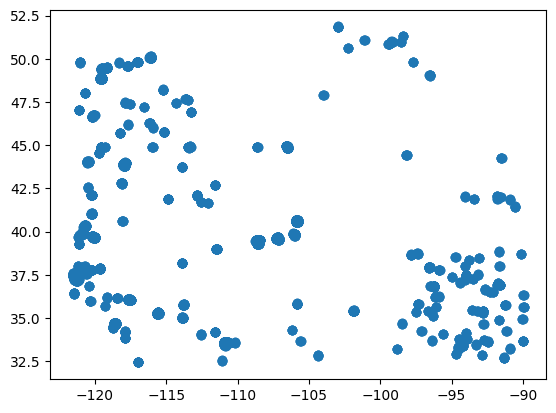

In [11]:
xC = []
yC = []
fp = firepoints.getInfo()["features"]
for i in range(547):
  for coord in fp[i]["geometry"]["coordinates"]:
    for c in coord:
      xC.append(c[0])
      yC.append(c[1])

print(xC)
print(yC)
plt.scatter(xC, yC)
plt.show()


In [ ]:
np.column_stack((yC,xC))

In [12]:
from sklearn.cluster import DBSCAN
from geopy.distance import geodesic

def get_distance(c1, c2):
    diff = c1 - c2
    d1 = diff[0] * 110.574
    d2 = diff[1] * 111.320 * np.cos(np.radians(diff[0]))
    return np.sqrt(d1**2 + d2**2)


coords = np.column_stack((yC,xC))


db = DBSCAN(eps = 10, min_samples = 2, metric = get_distance)
db.fit(coords)
labels = db.labels_


In [13]:
labels

array([  0,   0,   0, ..., 167, 167, 167])

In [14]:
def calc_Centroid(coords):
    x_coords, y_coords = coords[:, 0], coords[:, 1]
    centroid_x = np.mean(x_coords)
    centroid_y = np.mean(y_coords)
    return [centroid_x, centroid_y]

centroids = []
for c in range(max(labels)+1):
  c_coords = coords[labels == c]
  centroids.append(calc_Centroid(c_coords))
centroids = np.array(centroids)

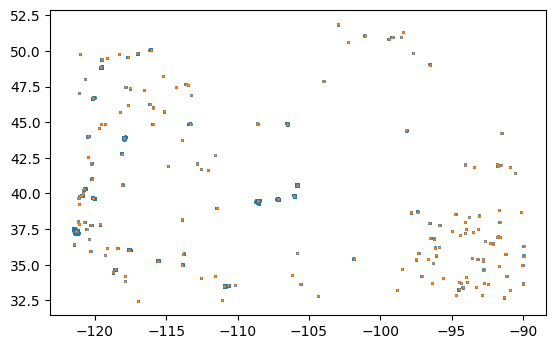

In [15]:
plt.scatter(xC, yC,s = 1)
plt.scatter(centroids[:,1],centroids[:,0], s = 1)
ax = plt.gca()
ax.set_aspect('equal')
plt.show()

In [16]:
# Prepare fire mask for sampling
MOD14A1 = ee.ImageCollection('MODIS/061/MOD14A1').select('FireMask').filterDate('2020-08-16', '2020-08-22')
fire_mask = MOD14A1
feature = fire_mask.max()  # Mosaic of fires across week timeframe
mask_points = feature.gt(6) # index of points > 6
feature = feature.updateMask(mask_points)
fire_image = feature.reproject(crs='EPSG:4326', scale=1000)

In [17]:
# Prepare NDVI for sampling
VNP13A1 =  ee.ImageCollection("NASA/VIIRS/002/VNP13A1").select('NDVI').filterDate('2020-08-16', '2020-08-22')
veg_image = VNP13A1.first().reproject(crs='EPSG:4326', scale=1000)

In [18]:
# Prepare Elevation for sampling
SRTM = ee.Image("USGS/SRTMGL1_003").select('elevation')
el_image = SRTM.reproject(crs='EPSG:4326', scale=1000)

In [19]:
# Prepare Drought for sampling
DROU = ee.ImageCollection("GRIDMET/DROUGHT").select("pdsi").filterDate('2020-08-16', '2020-08-22')
drought_image = DROU.first().reproject(crs='EPSG:4326', scale=1000)

In [20]:
# Prepare weather data for sampling
GRIDMET = ee.ImageCollection('IDAHO_EPSCOR/GRIDMET').filterDate('2020-08-16', '2020-08-22')
imageG = GRIDMET.first().reproject(crs='EPSG:4326', scale=1000)

In [24]:
# Weather samples
valsW = {}
band_list = ["pr", "tmmn", "tmmx", "erc", "th", "vs", "sph"]
for band in band_list:
  dataG = imageG.sampleRectangle(region = ROI, properties=[band], defaultValue=0)
  g_dict = dataG.getInfo()
  print(g_dict)
  valsW[band] = g_dict['properties'][band]

EEException: Image.sampleRectangle: Too many pixels in sample; must be <= 262144. Got 1264368.

In [21]:
@retry.Retry()
def get_patch(coords, image, band):
  """Get a patch of pixels from an asset, centered on the coords."""
  #print(coords)
  #print(p_bounds.getInfo())
  data = image.sampleRectangle(
        region=coords,
        properties=[band],
        defaultValue=0
    )
  # Access the pixel value directly from the data dictionary
  patch = data.getInfo()['properties'][band]

  return patch


In [22]:

import time
import concurrent.futures

executor = concurrent.futures.ThreadPoolExecutor(max_workers=200)
image_list = [fire_image, veg_image, el_image, drought_image, imageG]
band_list = [['FireMask'], ['NDVI'], ['elevation'], ['pdsi'], ["pr", "tmmn", "tmmx", "erc", "th", "vs", "sph"]]
i = 0
all_futures = []
image_patches = {}
for centroid in centroids:
    lat1 = centroid[0]-1.167595818185107/2
    long1 = centroid[1] + 66/(126*np.cos(np.deg2rad(lat1)))

    lat2 = centroid[0]+1.167595818185107/2
    long2 = centroid[1] - 66/(126*np.cos(np.deg2rad(lat2)))
    ROI = ee.Geometry.Rectangle(
      [long1, lat1,
      long2, lat2])
    image_patches[tuple(centroid)] = {}
    for i, image in enumerate(image_list):
        for band in band_list[i]:
            # Submit tasks for each band of each image
            future = executor.submit(get_patch, ROI, image, band)
            image_patches[tuple(centroid)][future] = (image, band) # Store image and band for later retrieval
            all_futures.append(future)



concurrent.futures.wait(all_futures)
print("Done")
test_dict = {}

# for future in concurrent.futures.as_completed(image_patches):
#     try:
#       np_array = future.result()
#       fig, ax = plt.subplots()

#       # Display the patch using imshow
#       # Note: You might need to adjust the colormap (cmap) and other parameters
#       # based on the type of data in your patches
#       im = ax.imshow(np_array, cmap='viridis')
#       plt.title(image_patches[future.result][1])

#       # Add a colorbar for better visualization
#       plt.colorbar(im, ax=ax)

#       # Show the plot
#       plt.show()
#       time.sleep(5)
#     except Exception as e:
#       print(e)
#       pass

Done


In [23]:
name_dict = {
    "FireMask": "Fire Mask",
    "NDVI": "Vegatative index",
    "elevation": "Elevation",
    "pdsi": "Drought",
    "pr": "Precipitation",
    "tmmn": "Min Temp",
    "tmmx": "Max Temp",
    "th": "Wind Direction",
    "vs": "Wind Speed",
    "sph": "Relative Humidity",
    "erc": "Energy Release Coeffecient"
}

In [24]:
def clip_np_array(array):
  h, w = array.shape
  dh = h - 128
  dw = w - 128
  return array[dh//2:-(dh-dh//2), dw//2:-(dw-dw//2)]

In [43]:
import tensorflow as tf

def dict_to_tfrecord(data_dict, output_filename):
  """Converts a dictionary to a TFRecord file."""

  with tf.io.TFRecordWriter(output_filename) as writer:
    # Create a tf.train.Example
    feature_dict = {}

    for future in data_dict:
      v = np.array(future.result())
      v = clip_np_array(v)
      image, band = image_patches[tuple(centroid)][future]
      feature_dict[name_dict[band]] = tf.train.Feature(float_list=tf.train.FloatList(value=list(v.flatten())))
      # Create a tf.train.Example

    example = tf.train.Example(features=tf.train.Features(feature=feature_dict))

    # Write the example to the TFRecord file
    writer.write(example.SerializeToString())

# Iterate through image_patches and save each dictionary
for centroid in image_patches:
  # Construct the output filename based on centroid coordinates
  output_filename = f'patch_{centroid[0]}_{centroid[1]}.tfrecord'

  # Convert and save the dictionary to a TFRecord file
  dict_to_tfrecord(image_patches[tuple(centroid)], output_filename)


print("TFRecord files created successfully.")

TFRecord files created successfully.


In [1]:
for centroid in image_patches:
  fig, ax = plt.subplots(2, 7, figsize=(20, 10))  # 3 rows, 1 column, adjusted figsize
  c = 0
  r = 0
  print(centroid)
  test_dict = {}
  for future in image_patches[tuple(centroid)]:
      data = future.result()
      image, band = image_patches[tuple(centroid)][future]
      test_dict[name_dict[band]] = data
      ax[r,c].imshow(data, cmap="jet")
      ax[r,c].set_title(band) # Add title for clarity

      c += 1
      if c >= 7:
        r +=1
        c = 0

  plt.tight_layout()
  plt.show()
  time.sleep(5)

NameError: name 'image_patches' is not defined

In [56]:
image_patches

{(35.77160562539636,
  -113.79996221577501): {<Future at 0x7cc753f38790 state=finished returned list>: (<ee.image.Image at 0x7cc753f1d570>,
   'FireMask'), <Future at 0x7cc753f38af0 state=finished returned list>: (<ee.image.Image at 0x7cc75870d9c0>,
   'NDVI'), <Future at 0x7cc753e8dd20 state=finished returned list>: (<ee.image.Image at 0x7cc75870c550>,
   'elevation'), <Future at 0x7cc75adcb2e0 state=finished returned list>: (<ee.image.Image at 0x7cc75870d6f0>,
   'pdsi'), <Future at 0x7cc75adcb160 state=finished returned list>: (<ee.image.Image at 0x7cc75870fdc0>,
   'pr'), <Future at 0x7cc75b415420 state=finished returned list>: (<ee.image.Image at 0x7cc75870fdc0>,
   'tmmn'), <Future at 0x7cc75b4156c0 state=finished returned list>: (<ee.image.Image at 0x7cc75870fdc0>,
   'tmmx'), <Future at 0x7cc75ad59000 state=finished returned list>: (<ee.image.Image at 0x7cc75870fdc0>,
   'erc'), <Future at 0x7cc753e8c550 state=finished returned list>: (<ee.image.Image at 0x7cc75870fdc0>,
   'th

In [43]:

import matplotlib.pyplot as plt

# Assuming you have the patches stored in a dictionary called 'image_patches'
# where the keys are (image, band) tuples and the values are the patches

for (image, band), patch in image_patches.items():
    # Create a new figure and axes for each patch
    fig, ax = plt.subplots()

    # Display the patch using imshow
    # Note: You might need to adjust the colormap (cmap) and other parameters
    # based on the type of data in your patches
    im = ax.imshow(patch, cmap='viridis')

    # Set the title of the plot
    ax.set_title(f'{image} - {band}')

    # Add a colorbar for better visualization
    plt.colorbar(im, ax=ax)

    # Show the plot
    plt.show()

TypeError: cannot unpack non-iterable Future object

In [ ]:

from os import wait
import time
executor = concurrent.futures.ThreadPoolExecutor(max_workers=200)
# Sample 10x10 km rectangle centered at centroid
image_list = [fire_image, veg_image, el_image, drought_image, imageG]

for centroid in centroids:
  image_patches = {
              executor.submit(get_patch, centroid, fire_image, 'FireMask'): image['id'] for image in image_list
  }

In [ ]:

for centroid in centroids:
  # calculate ROI
  lat1 = centroid[0]-1.157595818185107/2
  long1 = centroid[1] + 64/(126*np.cos(np.deg2rad(lat1)))

  lat2 = centroid[0]+1.157595818185107/2
  long2 = centroid[1] - 64/(126*np.cos(np.deg2rad(lat2)))
  ROI = ee.Geometry.Rectangle(
    [long1, lat1,
    long2, lat2])
  # Fire mask data from MOD14A1 dataset
  dataF = fire_image.sampleRectangle(region = ROI, properties=['FireMask'], defaultValue=0)
  f_dict = dataF.getInfo()
  valsF = f_dict['properties']['FireMask']
  valsF = np.where(np.array(valsF) != 0, 1, 0)

  # Vegetative index data sample
  dataV = veg_image.sampleRectangle(region = ROI, properties=['NDVI'], defaultValue=0)
  v_dict = dataV.getInfo()
  valsV = v_dict['properties']['NDVI']


  # Elevation sample
  dataE = el_image.sampleRectangle(region = ROI, properties=['elevation'], defaultValue=0)
  e_dict = dataE.getInfo()
  valsE = e_dict['properties']['elevation']


  # Drought Sample
  dataD = drought_image.sampleRectangle(region = ROI, properties=['pdsi'], defaultValue=0)
  d_dict = dataD.getInfo()
  valsD = d_dict['properties']['pdsi']


  # Weather samples
  valsW = {}
  band_list = ["pr", "tmmn", "tmmx", "erc", "th", "vs", "sph"]
  for band in band_list:
    dataG = imageG.sampleRectangle(region = ROI, properties=[band], defaultValue=0)
    g_dict = dataG.getInfo()
    valsW[band] = g_dict['properties'][band]

  print("test")


  # fig, ax = plt.subplots(2, 7, figsize=(20, 10))  # 3 rows, 1 column, adjusted figsize

  # ax[0,0].imshow(valsF, cmap="gray")
  # ax[0,0].set_title("Fire Mask") # Add title for clarity

  # ax[0,1].imshow(valsV, cmap="jet")
  # ax[0,1].set_title("NDVI")

  # ax[0,2].imshow(valsE, cmap="jet")
  # ax[0,2].set_title("Elevation")

  # ax[0,3].imshow(valsD, cmap="jet")
  # ax[0,3].set_title("Drought")

  # for i in range(7):
  #   ax[1,i].imshow(valsW[band_list[i]], cmap="jet")
  #   ax[1,i].set_title(band_list[i])

  # plt.tight_layout()
  # plt.show()
  # time.sleep(5)

test
test
test
test
test


KeyboardInterrupt: 

## Image retrieval functions

This section has a function to get a 1000x1000 meter patch of pixels from an asset, centered on the provided coordinates, as a numpy array.  The function can be retried automatically by using the [Retry](https://googleapis.dev/python/google-api-core/latest/retry.html) decorator.  There is also a function to serialize a structured array to a `tf.Example` proto.

# Get patches from the images

In the variable declarations, there's a random sample in an arbitrary region of interest and a year range.  At each point in the sample, in each year, in each 16-day composite, get a patch.  The patch extraction is handled in multiple threads using a `ThreadPoolExecutor`.  Write into TFRecords where each record stores all patches for a (point, year) combination.

## Inspect the written files

The parsing function dynamically determines the shape and keys of each record, which may vary by point and year.  Once the data are parsed, they can be displayed as an animation: one year's worth of NDVI change in a patch centered on the point.

### Get an animation of the data in a record

See [this reference](https://matplotlib.org/stable/gallery/animation/dynamic_image.html) for details, including options to save the animation.